In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

In [3]:
figsize(10, 8)

In [4]:
freqs = [4.575, 5.625, 6.125, 7.175]
banks = ['A', 'B', 'C', 'D']

In [5]:
rc = 335.7133441444117
dc = 63.43802542905474

In [6]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [33]:
def calculate_sflux(bank='A', session='5', doplot=True, pixbeam=4.):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/datamaps_'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units !!
    # units now are Jy * beam area per pixel area
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    signal = gaussian_filter(signal, beam/pixbeam)
    shits = gaussian_filter(hits, beam/pixbeam)
    signal[mask] = np.nan
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= 1.
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0
    
    annulus = (radius >= 80./60.) & (radius <= 2.)
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0
    
    if doplot:
        figure()
        pc = pcolormesh(rabins, decbins, signal - np.nanmedian(signal[outerregion]))
        clim(-0.25, 0.25)
        cb = colorbar()
        xlabel('RA [degrees]')
        ylabel('DEC [degrees]')
        cb.set_label('Flux [Jy]')
        title('Bank '+bank)
        savefig('map'+bank+session)
    
    flux = np.nansum(signal[innerregion] - np.nanmedian(signal[outerregion]))
    return flux

In [18]:
def calculate_sflux(bank='A', session='5', doplot=True, pixbeam=2.):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/datamaps_'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units !!
    # units now are Jy * beam area per pixel area
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask]
    
    #signal = gaussian_filter(signal, beam/pixbeam)
    #shits = gaussian_filter(hits, beam/pixbeam)
    signal[mask] = np.nan
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= 1.
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0
    
    annulus = (radius >= 80./60.) & (radius <= 2.)
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0
    
    if doplot:
        figure()
        pc = pcolormesh(rabins, decbins, (signal - np.nanmedian(signal[outerregion])) / beamarea)
        clim(-0.015, 0.015)
        cb = colorbar()
        xlabel('RA [degrees]')
        ylabel('DEC [degrees]')
        cb.set_label('Flux [Jy /sr]')
        title('Bank '+bank)
        #savefig('map_nosmooth_2arcmin'+bank+session)
    
    signal *= units
    flux = np.nansum(signal[innerregion] - np.nanmedian(signal[outerregion]))
    return flux

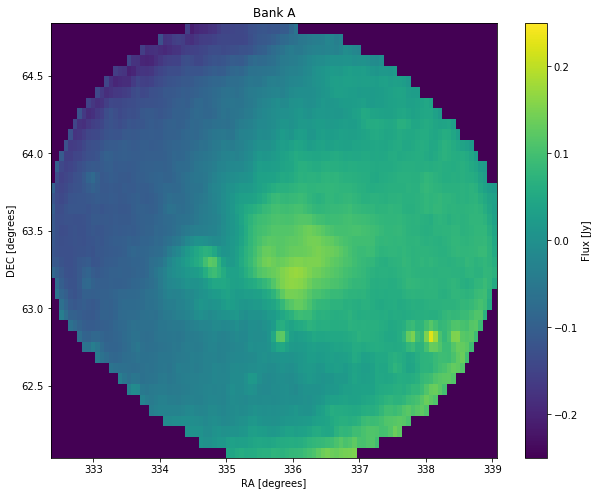

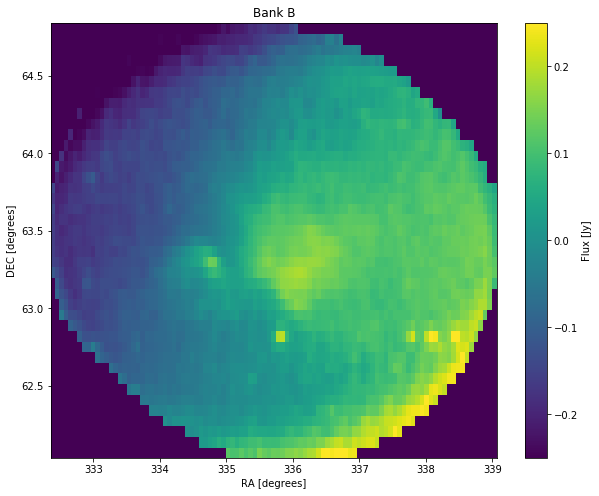

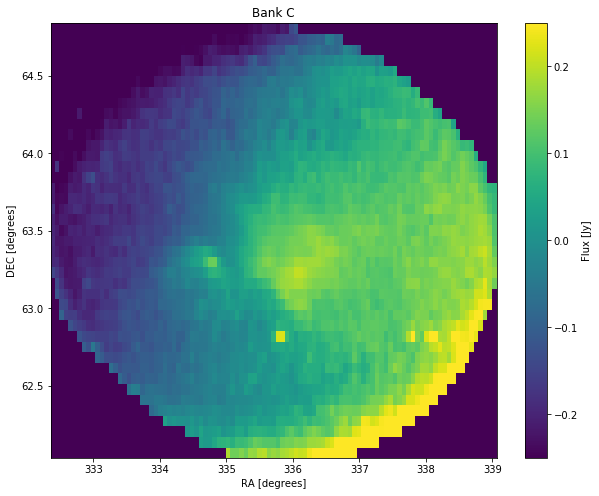

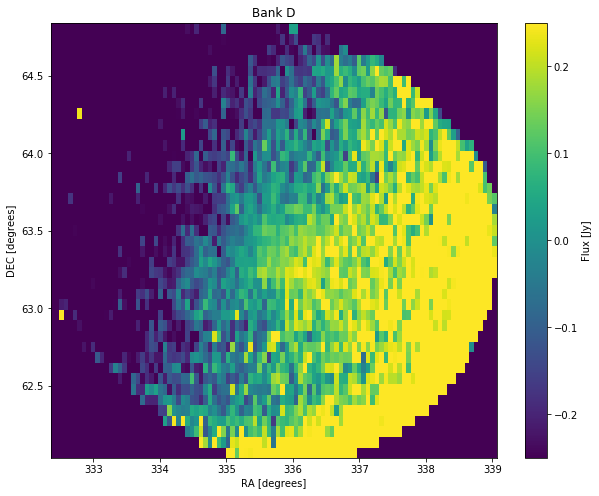

In [34]:
fluxs5 = []
for bank in banks:
    fluxs5.append(calculate_sflux(bank, '5'))

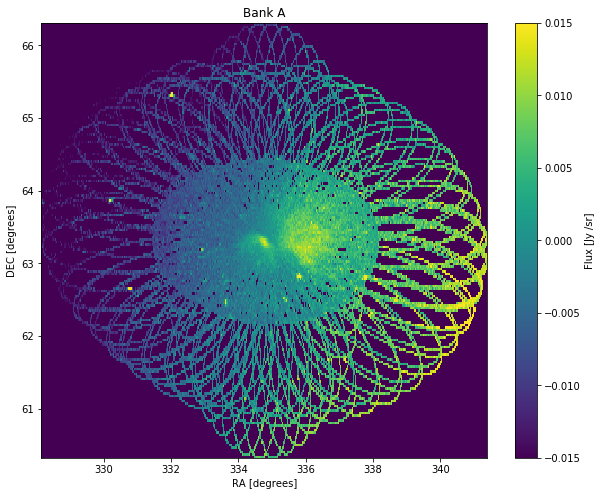

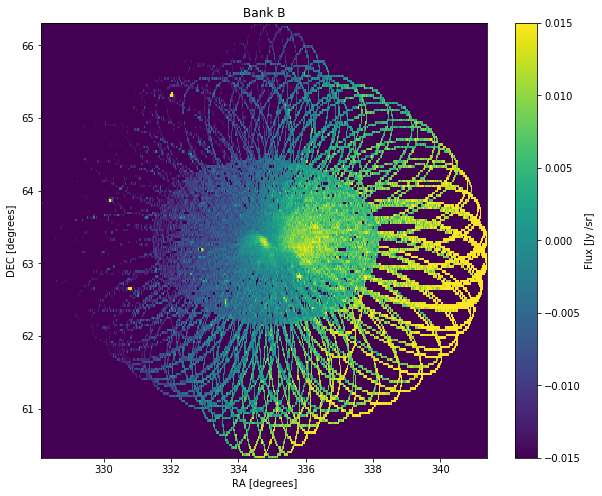

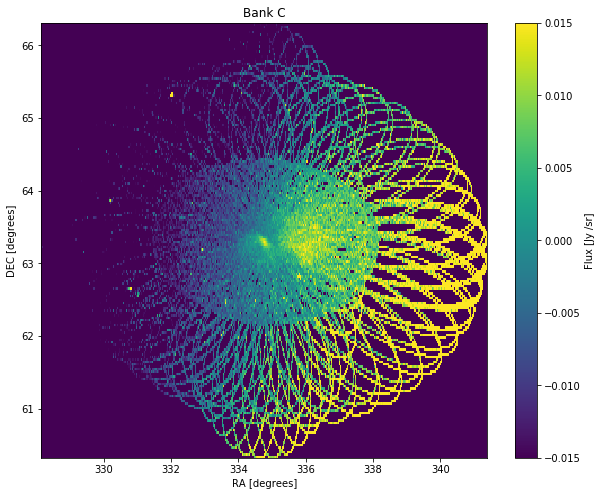

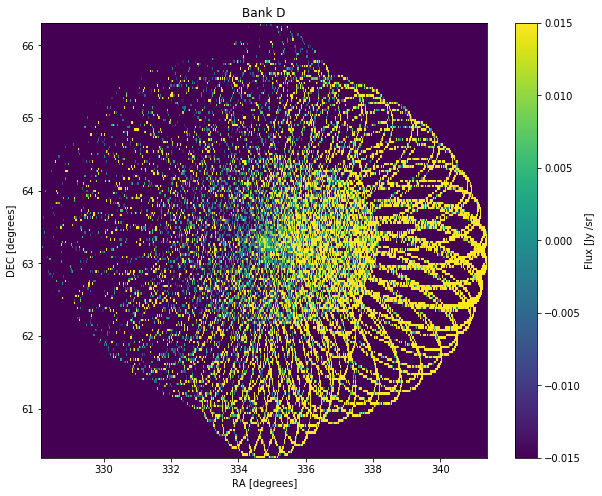

In [20]:
fluxs2 = []
for bank in banks:
    fluxs2.append(calculate_sflux(bank, '2'))

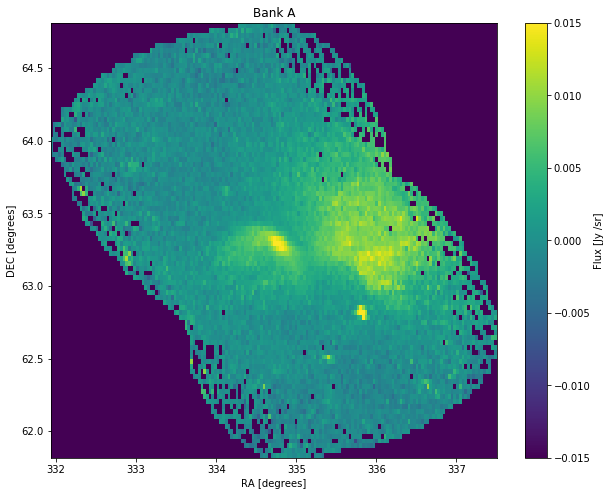

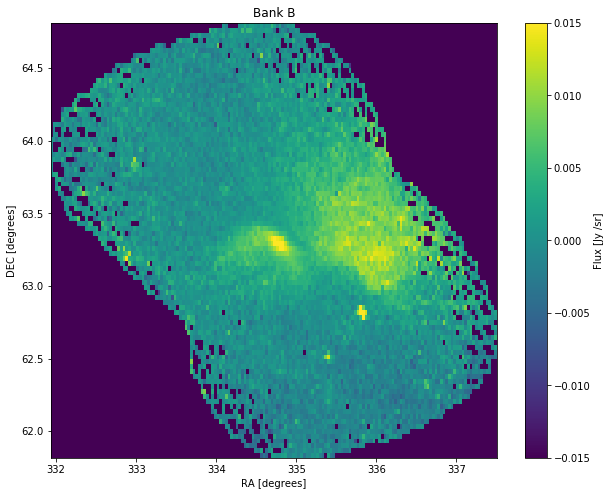

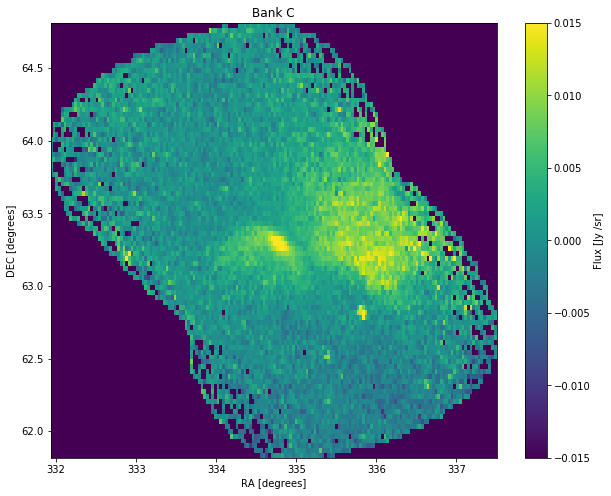

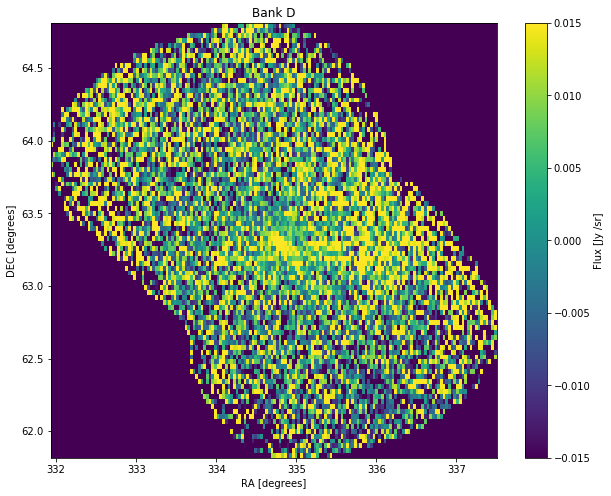

In [21]:
fluxs3 = []
for bank in banks:
    fluxs3.append(calculate_sflux(bank, '3'))

In [35]:
fluxs5 = []
for bank in banks:
    fluxs5.append(calculate_sflux(bank, '5', doplot=False))
fluxs2 = []
for bank in banks:
    fluxs2.append(calculate_sflux(bank, '2', doplot=False))
fluxs3 = []
for bank in banks:
    fluxs3.append(calculate_sflux(bank, '3', doplot=False))

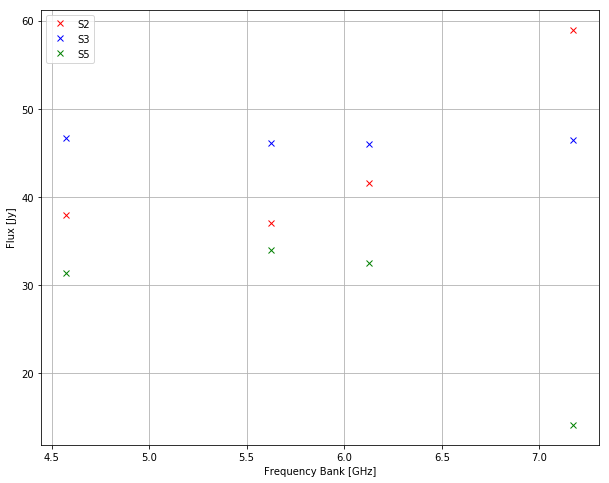

In [36]:
plot(freqs, fluxs2, 'xr', label='S2')
plot(freqs, fluxs3, 'xb', label='S3')
plot(freqs, fluxs5, 'xg', label='S5')
ylabel('Flux [Jy]')
xlabel('Frequency Bank [GHz]')
legend()
grid()

In [26]:
freqs = np.array(freqs)
df = 1.5 / 512 * 100

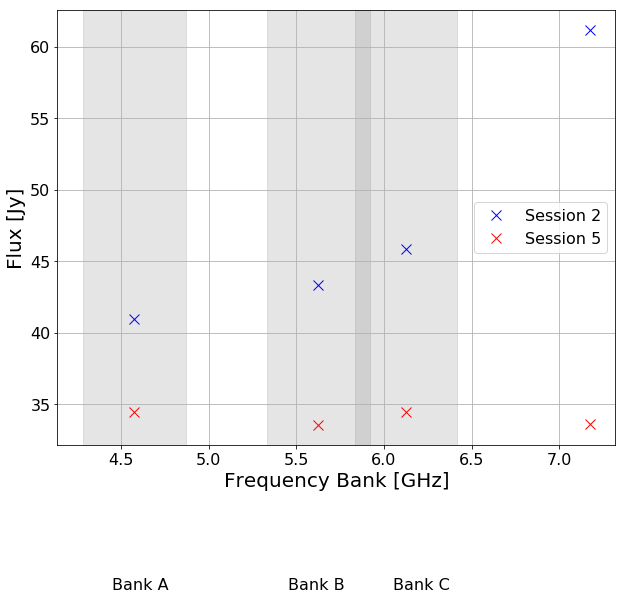

In [31]:
#plot(freqs, fluxs2, 'ro', fillstyle='none', markersize=10)
#plot(freqs, fluxs3, 'bo', fillstyle='none', markersize=10)
#plot(freqs, fluxs5, 'go', fillstyle='none', markersize=10)
plot(freqs, fluxs2, 'bx', label='Session 2', markersize=10)
#plot(freqs, fluxs3a, 'ko', alpha=0.1, label='S3', markersize=10)
plot(freqs, fluxs5, 'rx', label='Session 5', markersize=10)
ylabel('Flux [Jy]', fontsize=20)
xlabel('Frequency Bank [GHz]', fontsize=20)
axvspan(freqs[0]-df, freqs[0]+df, alpha=0.2, color='grey')
axvspan(freqs[1]-df, freqs[1]+df, alpha=0.2, color='grey')
axvspan(freqs[2]-df, freqs[2]+df, alpha=0.2, color='grey')
#xlim(4., 7.5)
#ylim(25, 55)
xticks(fontsize=16)
yticks(fontsize=16)
legend(fontsize=16)
grid()
text(4.45, 22, 'Bank A', fontsize=16)
text(5.45, 22, 'Bank B', fontsize=16)
text(6.05, 22, 'Bank C', fontsize=16)
#savefig('spectrumpoints.pdf', format='pdf')